# Basic reconstruction and generation VAE for CIFAR10

Inspired by homework 3

# Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=[20, 10])
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 3, 32, 32), out.view(-1, 3, 32, 32)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)

def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, 64).to(device)
        out = model.decode(z).view(-1, 3, 32, 32)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 3, 32, 32)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 3, 32, 32)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

cuda


# Dataset

In [ ]:
data_dir = 'data'
# CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
image = next(iter(data_loader))
image[0].shape

torch.Size([128, 3, 32, 32])

# VAE

In [ ]:
# Hyper-parameters
image_size = 3*32*32
h_dim = 400
z_dim = 64
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE(image_size=image_size, h_dim=h_dim, z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training

In [ ]:
num_epochs = 10

# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.mse_loss(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/10], Step [10/391], Reconst Loss: 58.7930, KL Div: 19.3796
Epoch[1/10], Step [20/391], Reconst Loss: 56.5752, KL Div: 18.1939
Epoch[1/10], Step [30/391], Reconst Loss: 57.4213, KL Div: 18.1001
Epoch[1/10], Step [40/391], Reconst Loss: 56.3965, KL Div: 18.2177
Epoch[1/10], Step [50/391], Reconst Loss: 58.7274, KL Div: 17.6146
Epoch[1/10], Step [60/391], Reconst Loss: 62.2302, KL Div: 18.5442
Epoch[1/10], Step [70/391], Reconst Loss: 58.9392, KL Div: 18.8102
Epoch[1/10], Step [80/391], Reconst Loss: 65.6897, KL Div: 18.3888
Epoch[1/10], Step [90/391], Reconst Loss: 58.6234, KL Div: 17.4734
Epoch[1/10], Step [100/391], Reconst Loss: 59.8609, KL Div: 18.0666
Epoch[1/10], Step [110/391], Reconst Loss: 61.4664, KL Div: 18.7145
Epoch[1/10], Step [120/391], Reconst Loss: 60.7152, KL Div: 17.4146
Epoch[1/10], Step [130/391], Reconst Loss: 57.4611, KL Div: 17.7106
Epoch[1/10], Step [140/391], Reconst Loss: 61.8725, KL Div: 17.8243
Epoch[1/10], Step [150/391], Reconst Loss: 60.1638, KL Di

# Results

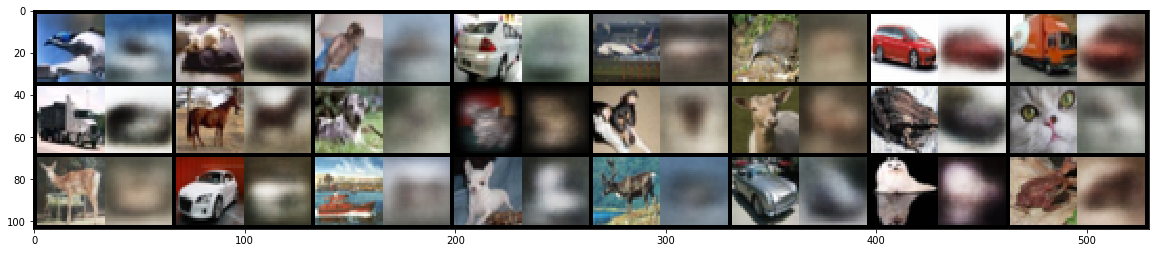

In [ ]:
plot_reconstruction(model)

Let's see now how our network generates new samples.

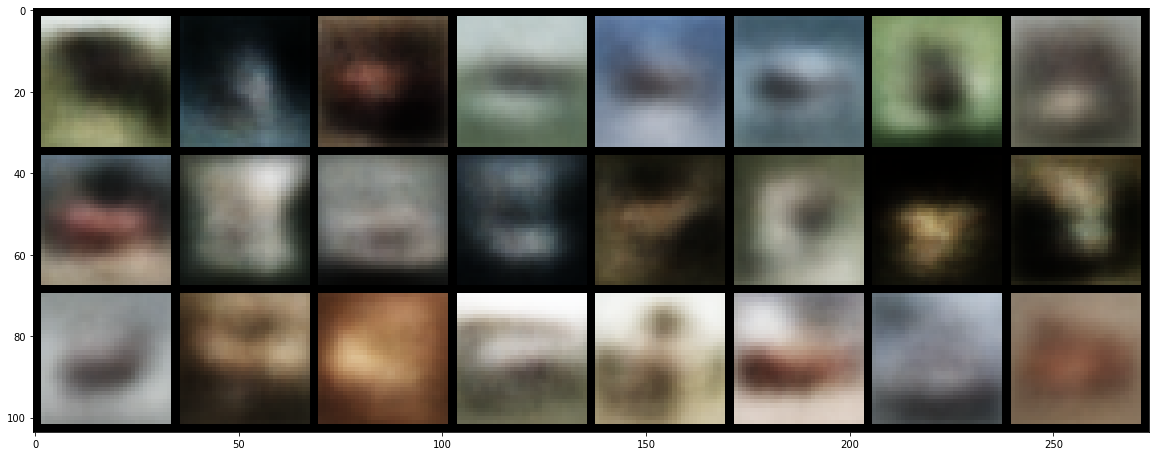

In [ ]:
plot_generation(model)